# Deep Fashion 2 product matching data generation

The purspose of this notebook is to prepare data ot be able to easily feed it into a siamese network for pattern matching training.

In [139]:
from collections import defaultdict
from dataclasses import dataclass

import json
import os
from typing import (
    List,
    Tuple
)
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

from data_loader import load_training_df

from visualization import display_instances

In [140]:
dataset_path = 'dataset'
output_dir = 'product_matching_dataset'
toy_output_dir = 'product_matching_dataset_toy'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(toy_output_dir, exist_ok=True)

In [141]:
df = load_training_df(dataset_path)

In [142]:
df.sample(5)

,segmentation,scale,viewpoint,zoom_in,landmarks,style,bounding_box,category_id,occlusion,category_name,source,pair_id,image_path
id,,,,,,,,,,,,,
95046,"[[489, 316, 365, 347, 270, 370, 276, 483, 277,...",2,2,1,"[270, 370, 1, 365, 347, 2, 489, 316, 1, 276, 4...",0,"[255, 314, 595, 609]",7,2,shorts,shop,7507,dataset/train/image/095046.jpg
169628,"[[198.0, 412.0, 243.0, 412.0, 304.0, 410.0, 33...",3,2,2,"[198, 412, 1, 331, 404, 1, 409, 349, 1, 181, 5...",0,"[170, 247, 748, 706]",8,2,trousers,shop,13292,dataset/train/image/169628.jpg
161295,"[[117, 1, 122, 21, 126, 45, 159, 48, 158, 29, ...",1,2,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[106, 0, 331, 112]",1,1,short sleeve top,shop,12630,dataset/train/image/161295.jpg
111409,"[[332, 4, 272, 45, 166, 44, 79, 3, 3, 3, 3, 38...",3,1,3,"[0, 0, 0, 0, 0, 0, 166, 44, 2, 272, 45, 2, 0, ...",1,"[0, 0, 466, 623]",1,1,short sleeve top,user,8817,dataset/train/image/111409.jpg
154587,"[[541, 751, 474, 754, 400, 754, 411, 869, 433,...",1,2,1,"[400, 754, 1, 474, 754, 1, 541, 751, 1, 411, 8...",1,"[394, 749, 586, 1196]",8,3,trousers,shop,12113,dataset/train/image/154587.jpg


Recall the following relevant columns:
    
    - `category_id`: Numeric id of the clothing element category.
    - `category_name`: String-formatted clothing element category.
    - `image_path`: Path to image relative to dataset image directory.
    - `bounding_box`: Bounding box of the clothing element in the image.
    - `pair_id`: Identifier that links two images containing the same clothing element.

## Generating training dataset

Get only relevant columns.

In [143]:
df = df[['bounding_box', 'category_id', 'category_name', 'pair_id', 'image_path']]

### Create supercategory map

Map images into supercategories to avoid having classes with low representation.

In [144]:
supercategory_map = {
    'short sleeve top': 'top',
    'long sleeve dress': 'dress',
    'trousers': 'trousers',
    'long sleeve top': 'top',
    'skirt': 'skirt',
    'shorts': 'shorts',
    'long sleeve outwear': 'outwear',
    'vest dress': 'dress',
    'short sleeve dress': 'dress',
    'vest': 'top',
    'sling dress': 'dress',
    'short sleeve outwear': 'outwear',
    'sling': 'top'
}

# Map category to supercategory
df.loc[:, 'supercategory_name'] = df.category_name.map(supercategory_map)

# Create id for supercategories
# Make sure ids start at 1
supercategory_id_map = {
    name: i + 1
    for i, name in enumerate(set(supercategory_map.values()))
}
df.loc[:, 'supercategory_id'] = df.supercategory_name.map(supercategory_id_map)

# Ensure no extra categories exist
assert set(supercategory_map.values()) == set(df.supercategory_name.unique())

In [145]:
df.sample(5)

,bounding_box,category_id,category_name,pair_id,image_path,supercategory_name,supercategory_id
id,,,,,,,
58678,"[73, 174, 379, 500]",2,long sleeve top,4643,dataset/train/image/058678.jpg,top,5
19532,"[0, 129, 465, 701]",4,long sleeve outwear,1543,dataset/train/image/019532.jpg,outwear,3
77548,"[457, 202, 553, 276]",7,shorts,6113,dataset/train/image/077548.jpg,shorts,2
190844,"[156, 80, 596, 1061]",8,trousers,14987,dataset/train/image/190844.jpg,trousers,1
100252,"[352, 329, 466, 609]",1,short sleeve top,7945,dataset/train/image/100252.jpg,top,5


## Remove potential ambiguous rows

Let's remove those images from the same pair that belong to two or more different clothing objects of the same type.

In [146]:
n_before = len(df)
df = df.drop_duplicates(subset=['pair_id', 'supercategory_name', 'image_path'], keep=False)
print(f'Remaining {len(df)} out of {n_before} rows')

Remaining 305382 out of 312186 rows


### Remove pair ids with less than 2 images

If less than two images are available for a specific pair, we won't be able to generate any triplets from it.

In [147]:
pair_category_count_df = df.groupby(['pair_id', 'supercategory_name']).count()['image_path'].reset_index(name='counts')
to_remove_df = pair_category_count_df[pair_category_count_df.counts == 1][['pair_id', 'supercategory_name']]

n_before = len(df)
df = df.merge(to_remove_df, how='left', indicator='to_remove')
df = df[df.to_remove == 'left_only'].drop('to_remove', axis=1)
print(f'Remaining {len(df)} out of {n_before} rows')

Remaining 302038 out of 305382 rows


### Visualize data.

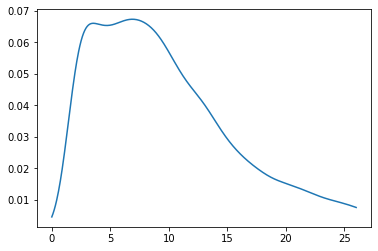

In [148]:
category_pair_counts = df.groupby(['pair_id', 'supercategory_name'])['image_path'].count()
kde = KernelDensity(kernel='gaussian', bandwidth=1.0)
kde = kde.fit(category_pair_counts.values[:, None])

xs = np.linspace(0, category_pair_counts.quantile(0.95), 500)
ys = kde.score_samples(xs[:, None])
plt.plot(xs, np.exp(ys));

We see most of the pair identifiers relate to several images (many of them between ~3 and ~8).

How are classes represented?

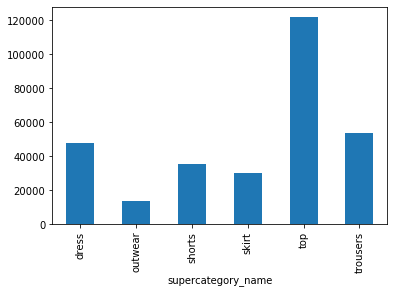

In [149]:
df.groupby('supercategory_name')['image_path'].count().plot.bar()

We see a high bias towards `tops` and `outweart` being substantially under-represented.

### Split between training, validation and test

In order to be able to measure how well the model generalizes, we will select non-overlapping pair ids for trianing, validation and testing.

In [150]:
all_pair_ids = df.pair_id.unique()
train_val_pair_ids, test_pair_ids = train_test_split(all_pair_ids,
                                                     test_size=0.125,
                                                     random_state=100)
train_pair_ids, val_pair_ids = train_test_split(train_val_pair_ids,
                                                test_size=0.125,
                                                random_state=250)

print(f'Number of pairs ids in training: {len(train_pair_ids)}')
print(f'Number of pairs ids in validation: {len(val_pair_ids)}')
print(f'Number of pairs ids in test: {len(test_pair_ids)}')

Number of pairs ids in training: 11060
Number of pairs ids in validation: 1580
Number of pairs ids in test: 1806


In [151]:
train_df = df[df.pair_id.isin(train_pair_ids)]
val_df = df[df.pair_id.isin(val_pair_ids)]
test_df = df[df.pair_id.isin(test_pair_ids)]

In [152]:
def abs_path_to_rel_path(path: str) -> str:
    return os.path.join('train', 'image', os.path.basename(path))


def build_dataset(instances: List[dict]) -> dict:
    """ Returns a dict-formatted dataset given a list of rows 
    
    The dictionary contains two main fields:
    
        - "category_to_pairs": Contains the list of available groups of
            product images indexed by category.
        - "pairs_to_data": Contains the individual instance data for each
            of the products in a "pair" indexed by category and then by pair id.
    
    """
    category_to_pair_ids = defaultdict(set)
    pair_id_to_data = defaultdict(lambda: defaultdict(list))

    for i, row in enumerate(instances):
        category_to_pair_ids[row['supercategory_name']] = \
            category_to_pair_ids[row['supercategory_name']].union({row['pair_id']})
        pair_id_to_data[row['supercategory_name']][row['pair_id']].append({
            'bounding_box': row['bounding_box'],
            'image_path': abs_path_to_rel_path(row['image_path'])
        })
    
    return {
        'category_to_pairs': category_to_pair_ids,
        'pairs_to_data': pair_id_to_data
    }

X_train = build_dataset(train_df.to_dict(orient='records'))
X_val = build_dataset(val_df.to_dict(orient='records'))
X_test = build_dataset(test_df.to_dict(orient='records'))

Serialize data.

In [153]:
def store_dataset(data: dict, dst_path: str) -> None:

    def serialize_sets(obj):
        if isinstance(obj, set):
            return list(obj)
        return obj

    with open(dst_path, 'w') as f:
        json.dump(data, f, default=serialize_sets)
        
store_dataset(X_train, os.path.join(output_dir, 'train.json'))
store_dataset(X_val, os.path.join(output_dir, 'validation.json'))
store_dataset(X_test, os.path.join(output_dir, 'test.json'))

## Generate toy dataset

This dataset will be used to check the training pipeline is able to learn and overfit a tiny dataset (will only be generating the training dataset).

In [154]:
pairs_subset = random.sample(list(df.pair_id.unique()), 5)
toy_df = df[df.pair_id.isin(pairs_subset)]
X_toy = build_dataset(toy_df.to_dict(orient='records'))
store_dataset(X_toy, os.path.join(toy_output_dir, 'train.json'))

## Visualize pair data

Let's visualize data form all sets to get a grasp of what king of data we are dealing with.

In [155]:
with open(os.path.join(output_dir, 'train.json'), 'r') as f:
    train_data = json.load(f)

with open(os.path.join(output_dir, 'validation.json'), 'r') as f:
    val_data = json.load(f)

with open(os.path.join(output_dir, 'test.json'), 'r') as f:
    test_data = json.load(f)

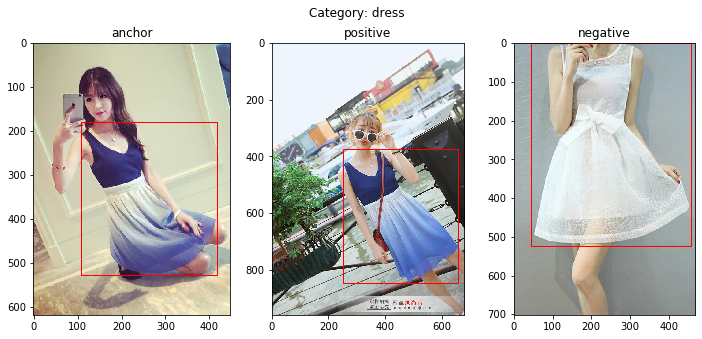

In [156]:
def visualize_triplet(category: str,
                      anchor: dict,
                      positive: dict,
                      negative: dict) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    
    def _plot_example(example, ax, tag) -> None:
        ax.imshow(plt.imread(os.path.join('dataset', example['image_path'])))
        ax.set_title(tag)
        x1, y1, x2, y2 = example['bounding_box'] 
        rect = patches.Rectangle((x1, y1),
                                 x2 - x1, y2 - y1,
                                 linewidth=1,
                                 edgecolor='r',
                                 facecolor='none')
        ax.add_patch(rect)
    
    _plot_example(anchor, axs[0], 'anchor')    
    _plot_example(positive, axs[1], 'positive')    
    _plot_example(negative, axs[2], 'negative')
    fig.suptitle(f'Category: {category}')
    
def sample_triplet(category: str, data: dict) -> Tuple[dict, dict, dict]:
    anchor_id, negative_id = random.sample(
        data['category_to_pairs'][category],
        2
    )
    anchor, positive = random.sample(
        data['pairs_to_data'][category][str(anchor_id)],
        2
    )
    negative = random.sample(
        data['pairs_to_data'][category][str(negative_id)],
        1
    )[0]
    return anchor, positive, negative


def sample_category(data: dict) -> str:
    assert data['category_to_pairs'].keys() == data['pairs_to_data'].keys()
    return random.choice(list(data['category_to_pairs'].keys()))

category_sample = sample_category(train_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, train_data)
)

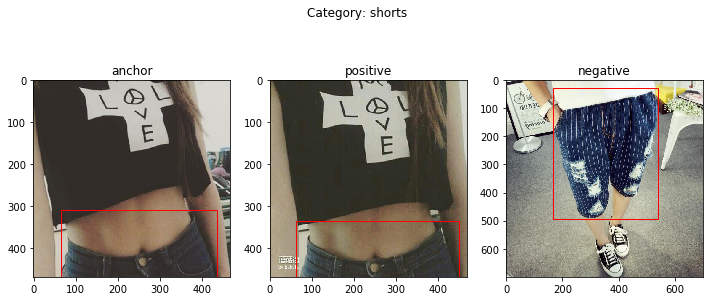

In [157]:
category_sample = sample_category(val_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, val_data)
)

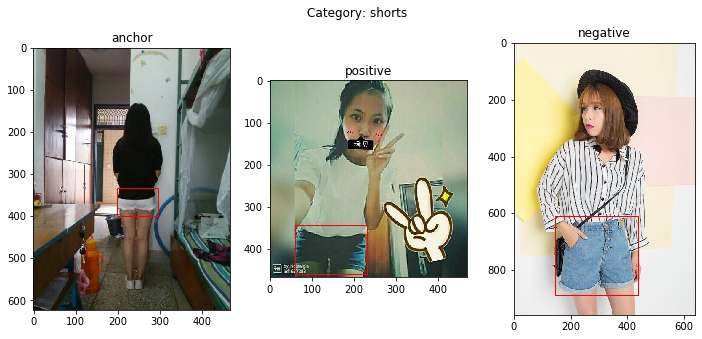

In [158]:
category_sample = sample_category(test_data)
visualize_triplet(
    category_sample,
    *sample_triplet(category_sample, test_data)
)

## Future work

- Use segmentation mask instead of bounding box. By doing so, we will prevent overfitting the background.